# Test Notebook Graph

In [2]:
import pandas as pd
from py2neo import Graph
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

# host + port
host = 'http://localhost:7474'

# select database name
db_name = 'modelcompact'

# credentials for API
user = 'neo4j'
passwd = '1234'

# connect to database
call_graph = Graph(host, auth=(user, passwd), name=db_name)

## Test functions here

### get molecules with more than 10 outgoing transformations and sort by weight

In [47]:
df_transformations = call_graph.run("""
MATCH (m:Molecule)-[t:HAS_TRANSFORMED_INTO]->(:Molecule)
WITH m, count(t) as count_HTI
MATCH (m2:Molecule)-[t:HAS_TRANSFORMED_INTO]->(:Molecule)
WHERE m.formula_string = m2.formula_string
AND m.sample_id = m2.sample_id
AND count_HTI >= 10
RETURN m2.formula_string as formula_string, m2.sample_id as sample_id, count_HTI as outgoing_transformations, collect({transformation_unit: t.transformation_unit, weight_combined: t.combined_weight, weight_connected: t.connected_weight}) as transformation_details
""").to_data_frame()

In [48]:
df_transformations = df_transformations.sort_values(by=['outgoing_transformations'], ascending=False).reset_index(drop=True)

In [50]:
full_sorted_list = []
for row in df_transformations.itertuples():
    sorted_list = sorted(row.transformation_details, key=lambda d: d['weight_connected'], reverse=True)
    #print(sorted_list)
    sorted_transformation_list = []
    for ele in sorted_list:
        sorted_transformation_list.append(ele['transformation_unit'])
    full_sorted_list.append(sorted_transformation_list)
df_transformations['sorted_transformations_connected_weight'] = full_sorted_list

In [55]:
df_transformations.to_csv('molecules_outgoing_transformations.csv', sep=',', encoding='utf-8', index=False)

### molecules with highest intensity variation and their outgoing transformations

#### top 100 most intensity gain

In [11]:
df_most_gain = call_graph.run("""
MATCH (m:Molecule)-[s:SAME_AS]->(m2:Molecule)
RETURN m.formula_string as formula_string, m.sample_id as sample_id_tp1, m.peak_relint_tic as relative_intensity_tp1,
m2.sample_id as sample_id_tp2, m2.peak_relint_tic as relative_intensity_tp2, s.intensity_trend as intensity_gain
ORDER BY s.intensity_trend DESC LIMIT 100
""").to_data_frame()

In [38]:
df_most_gain

,formula_string,sample_id_tp1,relative_intensity_tp1,sample_id_tp2,relative_intensity_tp2,intensity_gain
0,C18 H35 N1 O7,7857,0.000042,7863,0.000199,4.786
1,C14 H22 O1,7851,0.000085,7857,0.000395,4.661
2,C22 H39 N1 O3,7827,0.000027,7833,0.000122,4.549
3,C18 H36 O2,7839,0.002149,7845,0.008336,3.878
4,C10 H20 O2,7863,0.000251,7868,0.000941,3.757
...,...,...,...,...,...,...
95,C10 H6 O9,7809,0.000028,7815,0.000061,2.179
96,C16 H30 O5,7809,0.000092,7815,0.000199,2.169
97,C10 H18 O3,7809,0.000098,7815,0.000213,2.166
98,C8 H14 O3,7839,0.000038,7845,0.000081,2.153


In [62]:
df_most_gain.to_csv('molecules_most_intensity_gain.csv', sep=',', encoding='utf-8', index=False)

#### most intensity loss 

In [68]:
df_most_loss = call_graph.run("""
MATCH (m:Molecule)-[s:SAME_AS]->(m2:Molecule)
OPTIONAL MATCH (m)-[t:HAS_TRANSFORMED_INTO]->(:Molecule)
RETURN m.formula_string as formula_string, m.sample_id as sample_id_tp1, m.peak_relint_tic as relative_intensity_tp1,
m2.sample_id as sample_id_tp2, m2.peak_relint_tic as relative_intensity_tp2, s.intensity_trend as intensity_gain,
collect(t.transformation_unit) as outgoing_transformations
ORDER BY s.intensity_trend ASC LIMIT 100
""").to_data_frame()

In [69]:
df_most_loss

,formula_string,sample_id_tp1,relative_intensity_tp1,sample_id_tp2,relative_intensity_tp2,intensity_gain,outgoing_transformations
0,C22 H41 N1 O3,7815,0.000433,7821,0.000037,0.085,[]
1,C22 H43 N1 O1,7815,0.001337,7821,0.000125,0.093,[]
2,C22 H43 N1 O3,7815,0.000598,7821,0.000057,0.095,[]
3,C22 H41 N1 O2,7815,0.000822,7821,0.000083,0.101,[]
4,C22 H39 N1 O3,7815,0.000489,7821,0.000051,0.105,[]
...,...,...,...,...,...,...,...
95,C10 H20 O2,7857,0.000587,7863,0.000251,0.427,"[-C1 -H2 O1, -H2, -H2 O1, -H4 O2]"
96,C16 H31 N1 O5,7868,0.000347,7874,0.000148,0.427,[]
97,C13 H25 N1 O4,7851,0.000044,7857,0.000019,0.429,"[-C1 -H2 O1, O1, -H2 O1]"
98,C18 H35 N1 O7,7868,0.000373,7874,0.000160,0.429,[-H1 O1 -N1]


In [70]:
df_most_loss.to_csv('molecules_most_intensity_loss.csv', sep=',', encoding='utf-8', index=False)

### molecule property correlation

In [33]:
molecules = pd.read_csv('/home/philipp/Desktop/github/temporal-graphs-neo4j/models/files_for_model/ufz_all_formulas_cleaned.csv')
molecules = molecules[['formula_string','peak_intensity_rank']]
molecules = molecules.groupby(['formula_string']).mean().round(0).reset_index()

In [34]:
hits = call_graph.run("""
MATCH (m1:Molecule)
RETURN m1.formula_string as formula_string, m1.pregel_hub as hub_score, m1.pregel_auth as auth_score,
        m1.pregel_neulerhub as hti_hub_score, m1.pregel_neulerauth as hti_auth_score
""").to_data_frame()

In [35]:
molecules_hits = pd.merge(molecules, hits, left_on='formula_string', right_on='formula_string', how='left')

In [50]:
molecules_hits['norm_hub_score'] = (molecules_hits.hub_score-molecules_hits.hub_score.min())/(molecules_hits.hub_score.max()-molecules_hits.hub_score.min())
molecules_hits['norm_auth_score'] = (molecules_hits.auth_score-molecules_hits.auth_score.min())/(molecules_hits.auth_score.max()-molecules_hits.auth_score.min())
molecules_hits['norm_peak_rank'] = (molecules_hits.peak_intensity_rank-molecules_hits.peak_intensity_rank.min())/(molecules_hits.peak_intensity_rank.max()-molecules_hits.peak_intensity_rank.min())

In [51]:
molecules_hits[0:1000]

,formula_string,peak_intensity_rank,hub_score,auth_score,hti_hub_score,hti_auth_score,norm_hub_score,norm_auth_score,norm_peak_rank
0,C10 H10 N2 O12,7650.0,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.771201
1,C10 H10 N2 O2,8932.0,0.002071,2.586330e-03,0.002071,2.586330e-03,0.048145,5.754581e-02,0.900474
2,C10 H10 N2 O3,6508.0,0.003120,4.312931e-03,0.003120,4.312931e-03,0.072556,9.596265e-02,0.656045
3,C10 H10 N2 O4,5028.0,0.003666,5.186104e-03,0.003666,5.186104e-03,0.085244,1.153907e-01,0.506806
4,C10 H10 N2 O5,5575.0,0.003261,5.077730e-03,0.003261,5.077730e-03,0.075823,1.129794e-01,0.561964
...,...,...,...,...,...,...,...,...,...
995,C13 H16 O8 S1,4379.0,0.017067,1.659844e-02,0.017067,1.659844e-02,0.396852,3.693150e-01,0.441363
996,C13 H16 O9,405.0,0.018092,2.361901e-02,0.018092,2.361901e-02,0.420669,5.255226e-01,0.040637
997,C13 H16 O9 S1,6464.0,0.011641,1.158579e-02,0.011641,1.158579e-02,0.270667,2.577836e-01,0.651608
998,C13 H17 N1 O10,8628.0,0.004024,7.584895e-03,0.004024,7.584895e-03,0.093562,1.687638e-01,0.869820


<AxesSubplot:xlabel='norm_peak_rank', ylabel='norm_auth_score'>

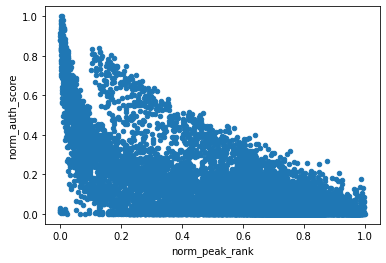

In [52]:
molecules_hits.plot.scatter(x='norm_peak_rank', y='norm_auth_score')